### Camera Calibration

In [2]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import pickle
import re
%matplotlib inline

### Camera Calibration

Camera lens introduces distortion at the edges, hence you find the ends of images to be slighly out of sync with the real world. It is important to correct this distortion as this might affect the calculations and decisions taken based on those calculations.

Camera Calibration is done by using images taken with the camera that has specific clearly defined points like in the case of a chess board. Even in this case, I calibrated the camera using sample images provided that were taken with this camera

Calibration is done using OpenCV functions - calibrate Images
Calibration returns the distortion co-efficients, distortion matrix. These can be used later to undistort the images.
Since Calibration is computationally intensive, the distortion co-efficients and matrix are saved to a Pickle

In [2]:
#Camera Calibration
def calibrate_camera():
    img_names = glob.glob('camera_cal/calibration*.jpg')
    print('No of Images {}'.format(len(img_names)))

    #Image points are the coordinates for image and Object points are coordinates for undistored 3D image
    objpoints = [] #3D with 3rd co-or always 0 since it is a plane
    imgpoints = [] #2D
    
    #Our board has x = 9 (0 - 8), y = 6 (0 - 5). If assuming corner right intersetction as (0, 0, 0), you'll have 9 * 6 intersections
    objp = np.zeros((9*6, 3), np.float32)

    """
    Generate coordinates for X, Y using mpgrid (assuming each box is 1*1 length)
    Z coordinate is 0, no need to populate it
    [:, :2] means all 9*6 values for 0th and 1st array, leaving 2nd which is for Z coordinate
    Reshape to 2 columns
    """
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    for img_name, i in zip(img_names, range(len(img_names))):

        #To create the image points, Look at the distorted image and use cv2(on gray scale) and detect corners
        img = cv2.imread(img_name)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(img_gray, (9, 6), None)
        #print('{}. Return value for Image {} --> {}'.format(i+1, img_name, ret))
        #If the function detects corners, then append those to image points
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp) #This is printing correctly
            #draw detected corners
            #img_draw = cv2.drawChessboardCorners(img, (8, 6), corners, ret)
            
    #Saving to a pickle
    img = cv2.imread('test_images/test2.jpg')
    shape = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    
    print('Camera Calibration Done!')

    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump(dist_pickle, open("data/calibration_pickle.p", 'wb'))
    
    
    return dist_pickle

calibrate_camera()

No of Images 20
Camera Calibration Done!


{'dist': array([[ -2.41017968e-01,  -5.30720497e-02,  -1.15810318e-03,
          -1.28318543e-04,   2.67124302e-02]]),
 'mtx': array([[  1.15396093e+03,   0.00000000e+00,   6.69705359e+02],
        [  0.00000000e+00,   1.14802495e+03,   3.85656232e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])}

### Displaying Output : Camera Calibration

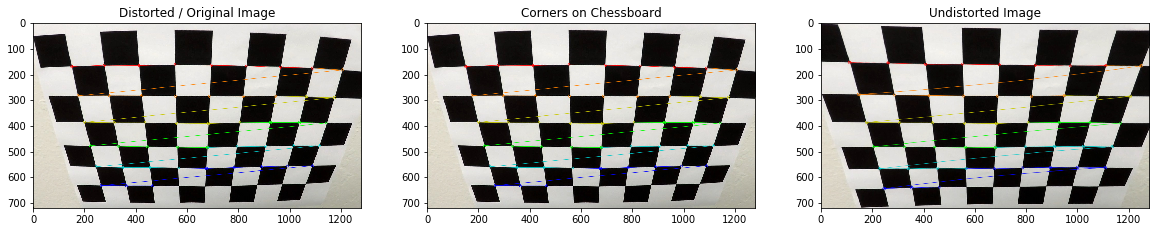

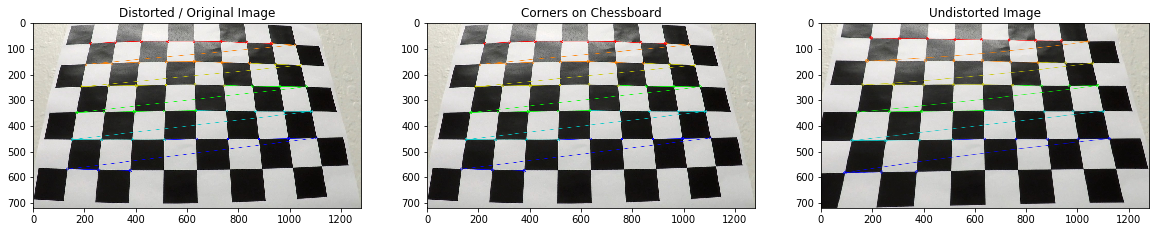

In [13]:
test_images = glob.glob('camera_cal/test_images/*.jpg')
dist_pickle = pickle.load( open('data/calibration_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']
for idx, image_name in enumerate(test_images):
    if idx < 3:
        img = cv2.imread(image_name)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(img_gray, (9, 6), None)
        if ret:
            img_draw = cv2.drawChessboardCorners(img, (8, 6), corners, ret)
            undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
            fig, axs = plt.subplots(1,3, figsize=(20, 10))
            axs[0].set_title('Distorted / Original Image')
            axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axs[1].set_title('Corners on Chessboard')
            axs[1].imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
            axs[2].set_title('Undistorted Image')
            axs[2].imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))

### Displaying Output : Undistorting Images

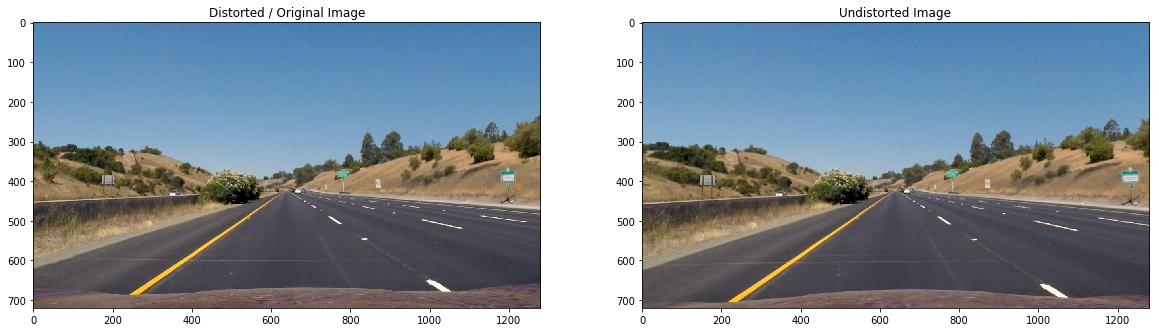

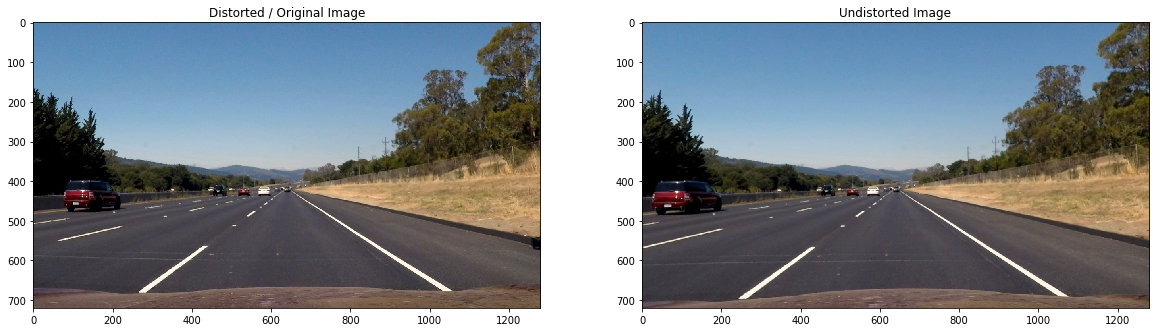

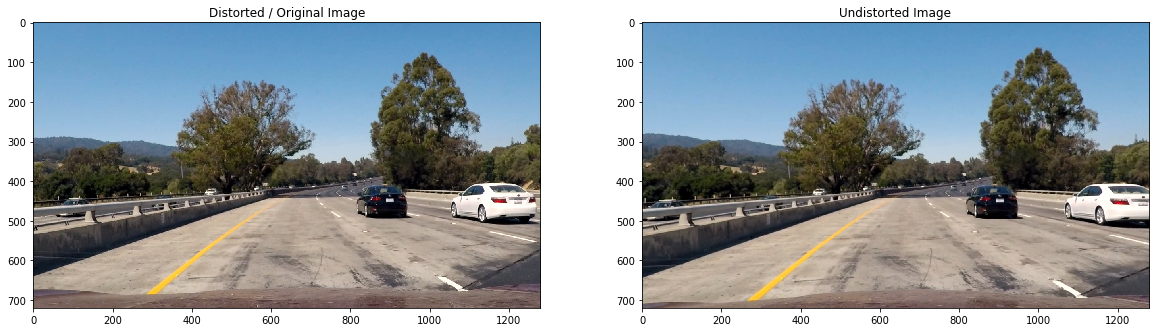

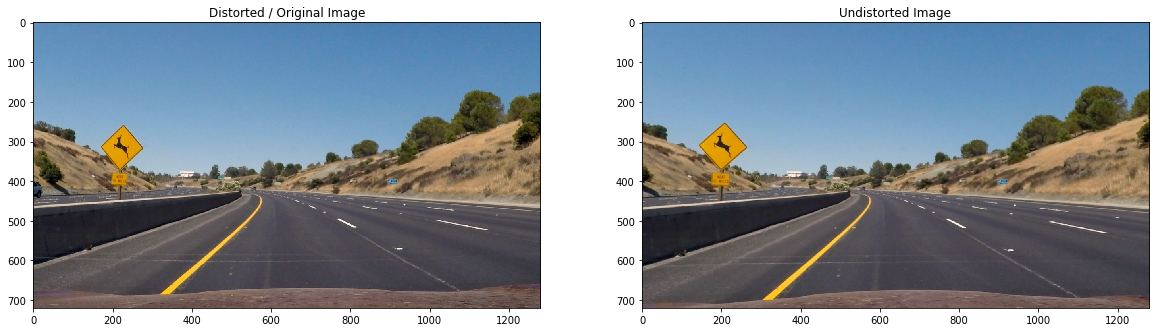

In [5]:
test_images = glob.glob('test_images/*.jpg')
dist_pickle = pickle.load( open('data/calibration_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']
for idx, image_name in enumerate(test_images):
    if idx < 4:
        img = cv2.imread(image_name)
        undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
        #Plotting
        fig, axs = plt.subplots(1,2, figsize=(20, 10))
        axs[0].set_title('Distorted / Original Image')
        axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[1].set_title('Undistorted Image')
        axs[1].imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))


### Loading the distortion co-efficients from Pickle

In [6]:
#Loading pickle
def load_pickle():
    dist_pickle = pickle.load( open('data/calibration_pickle.p', 'rb'))
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
    return mtx, dist

### Pre-Processing
It is a good practice to pre-process the images before determining the Lane Lines
This is bacause we want to filter out unwanted data and enhance the required features of the image to better classify the edges and determine the Lines.

Following pre-processing techniques are used in my pre-processing pipeline
- Sobel along X & Y Axis
- Magnitude Threshold
- Direction Threshold
- Extracting the 'Saturation' Channel from HLS Color space makes the evaluation independent to the lighting conditions

Once the above pre-processing are done, these are combined in the following way to get the resulting image
(SobelX & Sobel Y) OR (Magnitude Threshold & Direction Threshold) OR (Saturation Space)

- Region of Interest : 
We don't require the complete image to evaluate the Lane Lines. We just have to consider our own lane which will be of our interest. Hence create a mask in the form of a trapeziod along the current lane and determine the thresholded Image along this region

In [15]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Determine sobel for x or y
    Absolute soble
    uint8
    binary
    """
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        #print('inside x')
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobel)
    else:
        #print('inside y')
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobel)
        
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    img_binary = np.zeros_like(scaled_sobel)
    img_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return img_binary

def mag_thresh(image, mag_thresh=(0, 255), sobel_kernel=3):
    """
    Determine sobelx and sobely
    sqrt(x**2 + y**2)
    uint8
    binary
    """
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    sobel_mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))

    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, thresh, sobel_kernel=3):
    """
    Determine sobelx and sobely
    Absolute
    arctan2(y, x)
    binary
    """
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    dir_sobel = np.arctan2(sobely, sobelx)
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1
    return dir_binary

def color_threshold(img, sthresh=(0, 255), vthresh=(0, 255)):
    img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = img_hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
#     img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     v_channel = img_hsv[:,:,2]
#     v_binary = np.zeros_like(v_channel)
#     v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1

#     output = np.zeros_like(s_channel)
#     output[(s_binary == 1) & (v_binary == 1)] = 1
    
    return s_binary

def get_roi_image(img):
    height, width = img.shape[:2]
    ignore_mask_color = 255
    vertices = np.array([[(0, 0.95*height),(0.49*width,0.56*height),
                          (0.51*width,0.56*height),(width, 0.95*height)]], dtype=np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 1)
    
    roi_image = cv2.bitwise_and(img, mask)
    return roi_image

def apply_thresholds(img):
    #Thresholding
    sobelx = abs_sobel_thresh(img, 'x', 3, (30,125))
    sobely = abs_sobel_thresh(img, 'y', 3, (70,255))
    dir_binary = dir_threshold(img, (0.8, 1.2))
    mag_binary = mag_thresh(img, (40, 160))
    sv_channel = color_threshold(img, (100, 255), (90, 255))

    combined_binary = np.zeros_like(sobelx)
    combined_binary[(((sobelx == 1 )  & (sobely == 1 )) | ((dir_binary == 1)  & (mag_binary == 1)) | (sv_channel == 1))] = 1
    
    return combined_binary

### Displaying Output : Magnitude & Color Thresholds

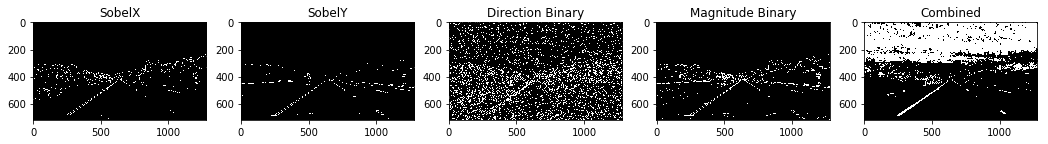

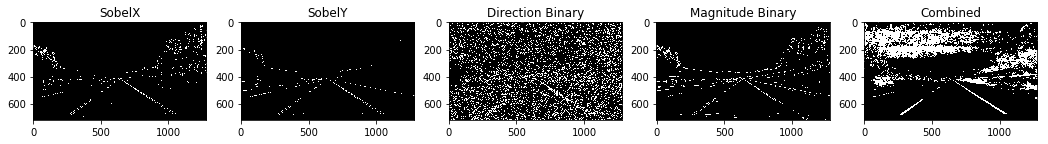

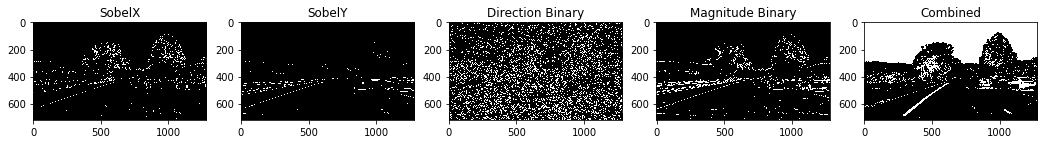

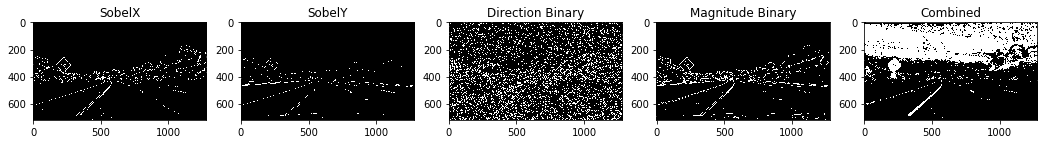

In [16]:
test_images = glob.glob('test_images/*.jpg')
for idx, image_name in enumerate(test_images):
    if idx < 4:
        img = cv2.imread(image_name)
        sobelx = abs_sobel_thresh(img, 'x', 3, (30,125))
        sobely = abs_sobel_thresh(img, 'y', 3, (70,255))
        dir_binary = dir_threshold(img, (0.8, 1.2))
        mag_binary = mag_thresh(img, (40, 160))
        sv_channel = color_threshold(img, (100, 255), (90, 255))

        combined_binary = np.zeros_like(sobelx)
        combined_binary[(((sobelx == 1 )  & (sobely == 1 )) | ((dir_binary == 1)  & (mag_binary == 1)) | (sv_channel == 1))] = 1

        fig, axs = plt.subplots(1,5, figsize=(18, 18))
        axs[0].set_title('SobelX')
        axs[0].imshow(sobelx, cmap='gray')
        axs[1].set_title('SobelY')
        axs[1].imshow(sobely, cmap='gray')
        axs[2].set_title('Direction Binary')
        axs[2].imshow(dir_binary, cmap='gray')
        axs[3].set_title('Magnitude Binary')
        axs[3].imshow(mag_binary, cmap='gray')
        axs[4].set_title('SV Channel')
        axs[4].imshow(sv_channel, cmap='gray')
        axs[4].set_title('Combined')
        axs[4].imshow(combined_binary, cmap='gray')

### Displaying Output : Region of Interest

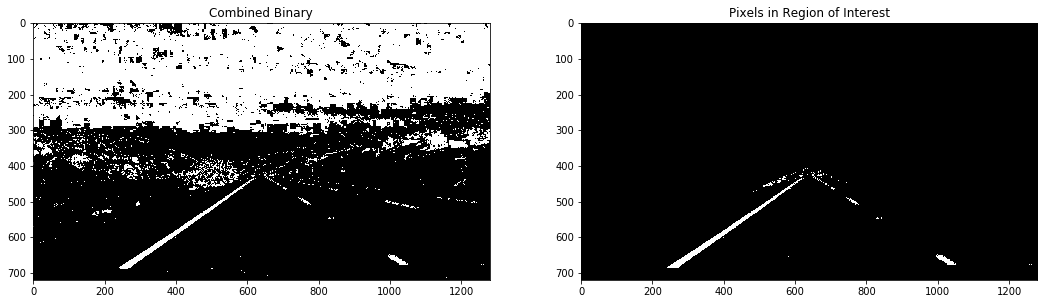

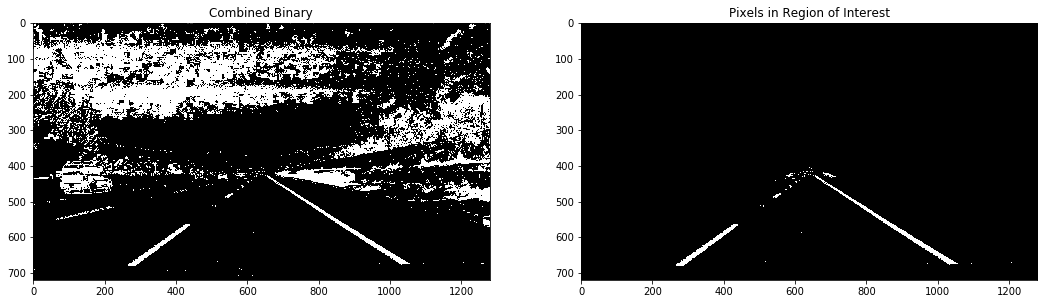

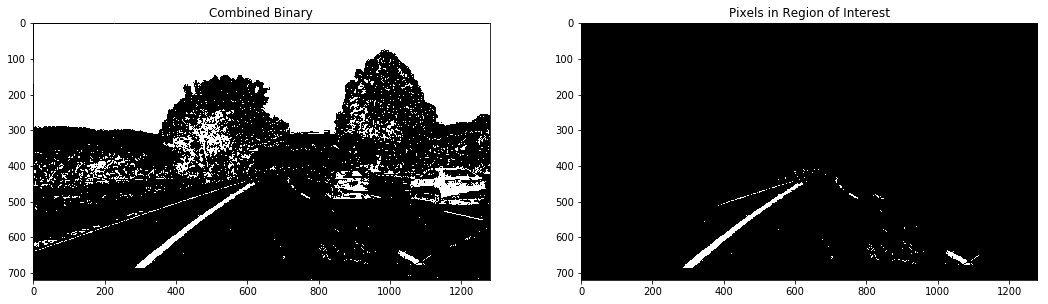

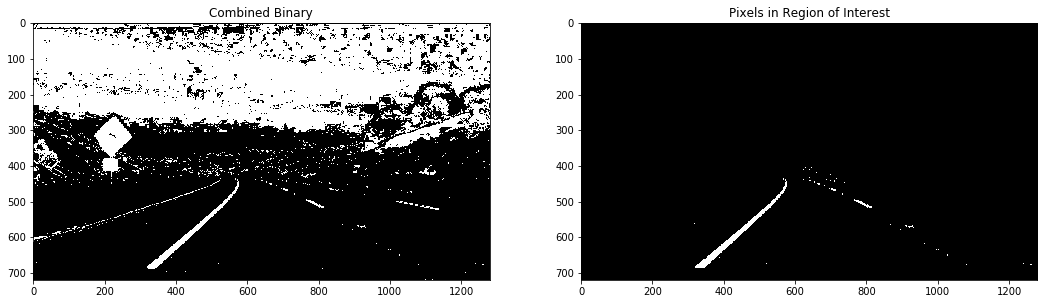

In [17]:
test_images = glob.glob('test_images/*.jpg')
for idx, image_name in enumerate(test_images):
    if idx < 4:
        img = cv2.imread(image_name)
        combined_binary = apply_thresholds(img)
        roi_image = get_roi_image(combined_binary)
        fig, axs = plt.subplots(1,2, figsize=(18, 18))
        axs[0].set_title('Combined Binary')
        axs[0].imshow(combined_binary, cmap='gray')
        axs[1].set_title('Pixels in Region of Interest')
        axs[1].imshow(roi_image, cmap='gray')

### Perspective Transformation
Lane Lines in fact are parallel but when you look the lane lines, they appear to be converging. THis is because of the perspective from which you are looking at the Lanes. If you look from a Bird Eye's view, the Lane Lines appear parallel.
This is what we'll do next using the OpenCV's cv2.getPerspectiveTransform

In order to do this, we will map the image points in the image view to object points in the 2D space which forms the Bird Eye's view

In [8]:
#Perspective Transformation
def warp_image(img):
    #Perspective tranform, M
    src = np.float32([[120,720],
                  [1110, 720],
                  [570, 470],
                  [722, 470]])
    dst = np.float32([[320,720],
                  [920, 720],
                  [320, 1],
                  [920, 1]])
    M = cv2.getPerspectiveTransform(src, dst)

    #Inverse Perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)

    img_size = (img.shape[1], img.shape[0])
    #warped image - uses linear interpolation
    warped_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped_img, Minv

### Displaying Output : Warped Image (BirdEye's View)

### Locate Lane Lines
#### First Instance, traverse through the entire image for highlights and determine the lines
#### Second Instance onwards, use the previous knowledge and search in restricted area

The following pipeline determines the Lane Lines in the Warped Image which is the BirdEye's view of the image in the regoin of interest.

#### function locate_lines
The Warped Image is first converted to a histogram which is done by summing up the pixel values along the columns in the bottom half of the image(top half is mostly the sky and unwanted data)

Using the histogram, it is easy to determine where the lane liines are - which are the peaks in the left half and the right half of the image

Once these are determined, the approach of window slicing is used (as explained in Chapter 15). The image is divided into n number of equal slices, and in each slice, the highest peaks are determined which form the lane lines in that slice. This process is repeated and a 2-degree polynomial is fit to the resulting points which form the lane lines.

You might think that the lines are already there, why to determine again - this is because we might have dashed lines on the road and it is important to draw a continous line.

#### function locate_lines_restricted
We don't have to repeat the above process of traversing through the whole image everytime because the lane lines in each subsequent frame of a video feed doesn't change much compared to its previous frame(note there are 24 frames per second in a regular video feed). Hence from the 2nd frame onwards, we will only do a search in a very constrained region - near to the previous resulting lane.
This is done by storing the values of the left and right pixels in a class(just to memorize the previous values) and use them to search along some margin across(100 px in this case).

In [28]:
def locate_lines(warped_img, nwindows=9, margin=100, minpix=50, show_values=True):
    histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
    #print('shape of binary warped', warped_img.shape)
    out_img = np.dstack((warped_img, warped_img, warped_img))*255
    #out_img = np.zeros_like(warped_img)
    #print('shape of dstack',out_img.shape)

    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    #print('Shape of Input Image {} Shape of Input Image {} midpoint {} left peak {} right peak {}'.format(warped_img.shape, histogram.shape, midpoint, leftx_base, rightx_base))

    nwindows = 9
    window_height = np.int(warped_img.shape[0] // nwindows)

    #Returns a tuple of arrays, one for each dimension of a, 
    #containing the indices of the non-zero elements in that dimension
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base
    #print('current left and right ', leftx_current, rightx_current)

    margin = 100
    minpix = 50

    left_lane_inds = []
    right_lane_inds = []

    for i in range(nwindows):
        #print('-----------------Window {} ------------------'.format(i))
        win_y_low = warped_img.shape[0] - (i+1) * window_height
        win_y_high = warped_img.shape[0] - i * window_height #This is the lower dimension

        #Left lane box
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        #Right lane box
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        #Drawing
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        #print('rectangles drawn')
        #non-zero pixels in x & y
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        #print('Length of good left {} good right {} '.format(len(good_left_inds), len(good_right_inds)))

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    #     print('Appending to left_lane_inds & right_lane_inds, current length {} {} '.format(len(left_lane_inds), len(right_lane_inds)))
    #     print('type of left_lane_inds & right_lane_inds {} {} '.format(type(left_lane_inds), type(right_lane_inds)))
    #     print('good pixels foudn in boxes ', len(good_left_inds), len(good_right_inds))
        '''
        Change the base x & y only if the pixel range is more than minpix value
        This is required because at places where there are no pixels (between dashes in lanes)
        you continue to go with the same base x and calculate the boxes. You don't want to
        alter the position of the box, you'll assume it as straight line between each dashed lines
        '''
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] ) #Defining no. of points in the graph
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    #Plotting using the same axs defined above
    if show_values == True:
        fig, axs = plt.subplots(1,2, figsize=(18, 18))
        axs[0].set_title('Warped Image')
        axs[0].imshow(warped_img)
        axs[1].set_title('Lane Lines Highlighted')
        axs[1].imshow(warped_img)
        axs[1].plot(left_fitx, ploty, color='red')
        axs[1].plot(right_fitx, ploty, color='red')
    
    #return left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy
    return left_fit, right_fit

#Calculating from next frame
def locate_lines_restricted(warped_img, left_fit, right_fit, show_values=True):
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100

    '''
        NZx & NZy are nonzero x & y
        LF & RF are left_fit & right_fit that is determined above
        left_lane_inds  = (NZx > LF[0]*NZy^2 + LF[1]*NZy + LF[2] - margin) & (NZx > LF[0]*NZy^2 + LF[1]*NZy + LF[2] + margin)
        right_lane_inds = (NZx > RF[0]*NZy^2 + RF[1]*NZy + RF[2] - margin) & (NZx > RF[0]*NZy^2 + RF[1]*NZy + RF[2] - margin)
        Observe only difference is in +/- margin for left and right indices

    '''
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #Vizualizing the Image - remember this is the 2nd frame and above
    out_img = np.dstack((warped_img, warped_img, warped_img))*255
    window_img = np.zeros_like(out_img)
    #Coloring left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    #This is the search window we are actually considering instead of the whole image
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))

    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    weighted_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    #Plotting
    if show_values == True:
        fig, axs = plt.subplots(1,2, figsize=(18, 18))
        axs[0].set_title('Warped Image')
        axs[0].imshow(warped_img)
        axs[1].set_title('Lane Lines Highlighted(Restricted Search)')
        axs[1].imshow(weighted_img)
        axs[1].plot(left_fitx, ploty, color='yellow')
        axs[1].plot(right_fitx, ploty, color='yellow')
    
    return left_fit, right_fit

### Sanity Check

Doing a highly constrained search for the Lane lines sometimes may backfire and result in a bad result. To avoid such scenarios, it is always better to do a check if the lane lines are following certain conditions like the line being almost parallel, and the mean difference between the lines is relatively small. This will ensure we are not deviating much from the previous frame.

If, for some reason, we fall into undesired results, then we follow the first path of traversing through the whole image in slices and determining the lines

In [10]:
#Lane Class for storing the values
class Lane():
    def __init__(self):
        self.last_left = None
        self.last_right = None
        self.left_fit = None
        self.right_fit = None
        self.counter = 0
        self.reset_counter = 0
        
lane = Lane()

#Sanity Check
def is_lane_valid(left_fit, right_fit):
    
    #Check if left and right fit returned a value
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False

    else:
        #Check distance b/w lines
        ploty = np.linspace(0, 20, num=10 )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        delta_lines = np.mean(right_fitx - left_fitx)
        if delta_lines >= 150 and delta_lines <=430: 
            status = True
        else:
            status = False
        
        # Calculate slope of left and right lanes at midpoint of y (i.e. 360)
        left = 2*left_fit[0]*360+left_fit[1]
        right = 2*right_fit[0]*360+right_fit[1]
        delta_slope_mid =  np.abs(left-right)
        
        #Check if lines are parallel at the middle
        if delta_slope_mid <= 0.1:
            status = True
        else:
            status = False
            
    return status

def line_finder(warped_img):
    #FINDING LINES
    if lane.counter == 0:
        #print('Evaluating full Image')
        lane.left_fit, lane.right_fit = locate_lines(warped_img, show_values=False)
    else:
        #print('Evaluating in restricted area')
        lane.left_fit, lane.right_fit = locate_lines_restricted(warped_img, lane.left_fit, lane.right_fit, False)
    
    #Sanity Check
    status = is_lane_valid(lane.left_fit, lane.right_fit)
    if status == True:   
        lane.last_left, lane.last_right = lane.left_fit, lane.right_fit        
        lane.counter += 1
        lane.reset_counter = 0
    else:   
        #Reset
        if lane.reset_counter > 4:
            #print('Reset counter less than 4 ', lane.reset_counter)
            lane.left_fit, lane.right_fit = locate_lines(warped_img, show_values=False)
            lane.reset_counter = 0
        else:
            #print('Reset counter greater than 4')
            lane.left_fit, lane.right_fit = lane.last_left, lane.last_right
        lane.reset_counter += 1
        
    return warped_img, lane.left_fit, lane.right_fit, Minv

In [29]:
#Radius of Curvature
def determine_curvature(warped_img, left_fit, right_fit):
    
    #You are still drawing based on your original fits
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
#     print('left fits in curvature', left_fit[0], left_fit[1], left_fit[2])
#     print('right fits in curvature', right_fit[0], right_fit[1], right_fit[2])
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # This is purely to evaluate the curvature in next step
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curvature =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate vehicle center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    # Lane center as mid of left and right lane bottom                        
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    img_center = warped_img.shape[1] / 2
    center = (lane_center - img_center)*xm_per_pix #Convert to meters
    position = "left" if center < 0 else "right"
    center = "Vehicle is {:.2f}m {}".format(center, position)
    
    # Now our radius of curvature is in meters
    return left_curvature, right_curvature, center

### Drawing on the final image

In [30]:
def draw_on_image(undist, warped_img, left_fit, right_fit, Minv, left_curvature, right_curvature, center, show_values = False):
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curvature), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curvature), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, '{}'.format(center), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    if show_values == True:
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        
    return result

### Pre-processing Pipeline

In [14]:
def preprocess_image(img, image_name, show_values=True):
    mtx, dist = load_pickle()
    
    #PRE PROCESSING
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    threshold_binary = apply_thresholds(undistorted_img)
    roi_image = get_roi_image(threshold_binary)
    warped_img, Minv = warp_image(roi_image)
    
    #Plotting
    if show_values == True:
        fig, axs = plt.subplots(1,5, figsize=(18, 18))
        axs[0].set_title('Input : '+re.search('test_images\\\(.*).jpg', image_name).group(1))
        axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[1].set_title('Undistorted Image')
        axs[1].imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
        axs[2].set_title('Thresholded Image')
        axs[2].imshow(threshold_binary)
        axs[3].set_title('Masked to Region of Interest')
        axs[3].imshow(roi_image)
        axs[4].set_title('Warped Perspective')
        axs[4].imshow(warped_img)
    return warped_img, Minv

### Executing on Images

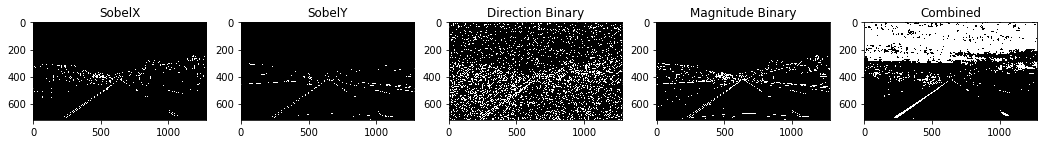

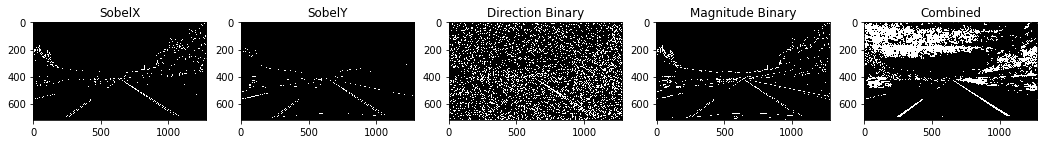

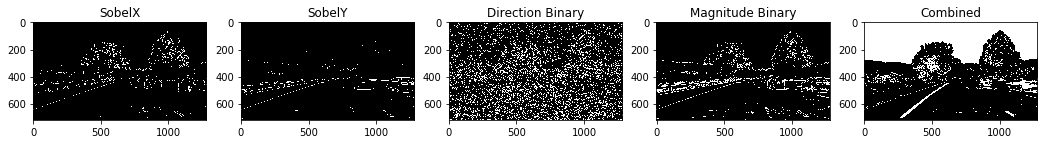

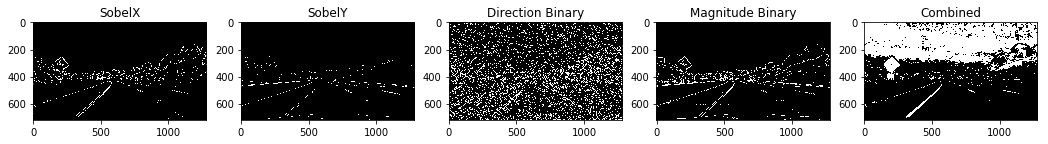

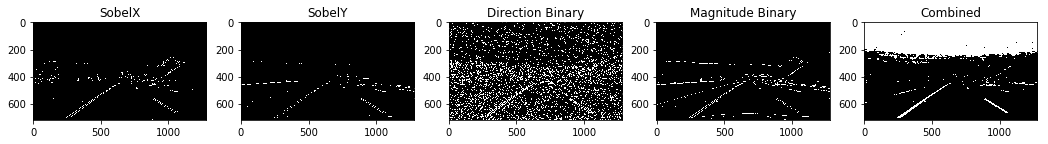

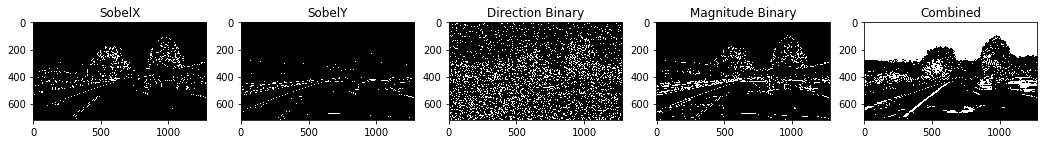

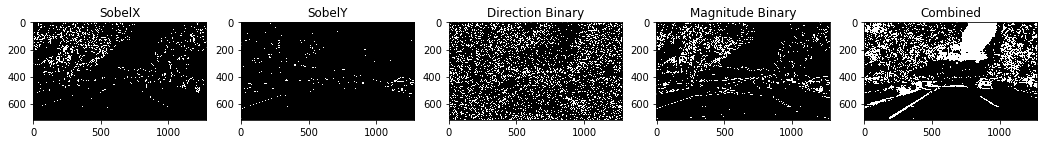

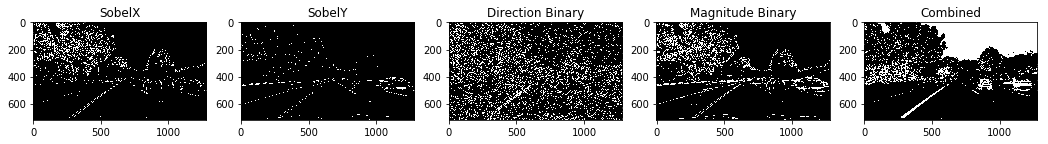

In [34]:
test_images = glob.glob('test_images/*.jpg')
for image_name in test_images:
    img = cv2.imread(image_name)
    warped_img, Minv = preprocess_image(img, image_name, False)
    warped_img, left_fit, right_fit, Minv = line_finder(warped_img)
    

    #CALCULATING RADIUS OF CURVATUER
    left_curvature, right_curvature, center = determine_curvature(warped_img, left_fit, right_fit)
    #print('Curvatures left {} right {} center {}'.format(left_curvature, right_curvature, center))
    #print(left_curvature, right_curvature, center)
    final_img = draw_on_image(img, warped_img, lane.left_fit, lane.right_fit, Minv, left_curvature, right_curvature, center, False)
    

### Running on a Video

In [ ]:
ft_curvature, right_curvature, center = determine_curvature(warped_img, left_fit, right_fit)
    #print('Curvatures left {} right {} center {}'.format(left_curvature, right_curvature, center))
    #print(left_curvature, right_curvature, center)
    final_img = draw_on_image(img, warped_img, lane.left_fit, lane.right_fit, Minv, left_curvature, right_curvature, center, displayImages)
    return final_img

#Reading from a video file

def process_video(image_name):
    return process_image(image_name)

def execute_video():
    video_output = 'output_videos/video_v1.mp4'
    video_feed = VideoFileClip('project_video.mp4')
    frame = video_feed.fl_image(process_video)
    %time frame.write_videofile(video_output, audio=False)
    HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(video_output))
execute_video()

[MoviePy] >>>> Building video output_videos/video_v1.mp4
[MoviePy] Writing video output_videos/video_v1.mp4


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 829/1261 [11:03<05:30,  1.31it/s]